# Data Scientist Professional
## Practical Exam Solution


## Data Validation
This dataset has 947 rows, 8 columns. I have validated all variables and i have made some changes for columns that were not as described in the data dictionary.

- recipe : without missing values. No cleaning is needed.
- calories : 50+ missing values, his variation coefficient was more than 25%, so i replace na with the median.
- carbohydrate : 50+ missing values, his variation coefficient was more than 25%, so i replace na with the median.
- sugar : 50+ missing values, his variation coefficient was more than 25%, so i replace na with the median.
- protein : 50+ missing values, his variation coefficient was more than 25%, so i replace na with the median.
- category : instead of 10 groups there was 11, so we replaced this modality ('Chicken Breast') by 'Chicken'.
- servings : without missing values, but the column was not numerical as expected and some values had the string " as a snack", so we removed that string and convert "servings" into int.
- high_traffic : that column had 300 + missing values, we had assumed that the were referring to "Non High" traffic recipes, and replace the na by "Not High".
We dropped the recipe number column, because it's not usefull for the analysis. Finaly our dataset has 947 rows, 7 columns.

In [220]:
# import all the librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import pingouin as pg
from scipy.stats import chi2_contingency
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
# set the seed for future usages
SEED  = 42
# define the plot style to use
style.use('ggplot')

In [221]:
df = pd.read_csv('data/recipe_site_traffic_2212.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [222]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [223]:
# we need to define a function to calculate the variation coefficient for numerical variables (in percent)
cv = lambda x:np.std(x,ddof = 1) / np.mean(x) *100 

In [224]:
# calculate variation coefficient for variables which have na
df[["calories","carbohydrate","sugar","protein"]].apply(cv)

calories        103.918391
carbohydrate    125.319185
sugar           162.262740
protein         150.603721
dtype: float64

In [225]:
# all the numerical variables with na have a cv greater than 25% , so we need to replace na with the median
def replace_missing_with_median(df, cols):
    for col in cols:
        median = df[col].median()
        df[col] = df[col].apply(lambda x: median if pd.isna(x) else x)
    return df

In [226]:
# apply our function to df
df = replace_missing_with_median(df, ["calories","carbohydrate","sugar","protein"])

In [227]:
# verify the result
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,947.000000,947.000000,947.000000,947.000000
mean,474.000000,427.846019,34.323464,8.799641,23.416283
std,273.519652,441.673556,42.836191,14.306785,35.486699
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,114.410000,9.135000,1.795000,3.465000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,576.225000,42.590000,9.285000,28.530000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [228]:
# the servings col does not have any missing values but we need to clean it 
# in order to remove the string "as a snack" and convert it into numerical
set(df["servings"])

{'1', '2', '4', '4 as a snack', '6', '6 as a snack'}

In [229]:
# clean and convert the column servings to int 
df["servings"] = df["servings"].str.replace(" as a snack","").astype(int)

In [230]:
# verify the result
df.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,947.000000,947.000000,947.000000,947.000000,947.000000,947.000000
mean,474.000000,427.846019,34.323464,8.799641,23.416283,3.477297
std,273.519652,441.673556,42.836191,14.306785,35.486699,1.732741
min,1.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,114.410000,9.135000,1.795000,3.465000,2.000000
50%,474.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,710.500000,576.225000,42.590000,9.285000,28.530000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


In [231]:
# in the category column, we have a supplementary recipe not ten
# we need to replace "Chicken Breast" by "Chicken"
set(df["category"])

{'Beverages',
 'Breakfast',
 'Chicken',
 'Chicken Breast',
 'Dessert',
 'Lunch/Snacks',
 'Meat',
 'One Dish Meal',
 'Pork',
 'Potato',
 'Vegetable'}

In [232]:
df["category"] = df["category"].str.replace('Chicken Breast','Chicken')

In [233]:
# verify that we have ten recipes in category
set(df["category"])

{'Beverages',
 'Breakfast',
 'Chicken',
 'Dessert',
 'Lunch/Snacks',
 'Meat',
 'One Dish Meal',
 'Pork',
 'Potato',
 'Vegetable'}

In [234]:
# for the high_trafic colum, we are going to assume that if a recipe high_trafic
# is marked as nan , then that recipe does not have a high trafic
df.loc[df["high_traffic"].isna(),"high_traffic"] = "Not High"

In [235]:
set(df["high_traffic"])

{'High', 'Not High'}

In [236]:
# recode the values of the popularity
df["high_traffic"] = [1 if val=="High" else 0 for val in df["high_traffic"].values]

In [237]:
df["high_traffic"].value_counts(normalize=True)

1    0.606125
0    0.393875
Name: high_traffic, dtype: float64

In [238]:
# get a final overview of data after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    int32  
 7   high_traffic  947 non-null    int64  
dtypes: float64(4), int32(1), int64(2), object(1)
memory usage: 55.6+ KB


In [239]:
df.drop(columns=["recipe"], axis = 1,inplace = True)

## Exploratory Analysis

I have investigated the target variable, features of a recipe, and the relationship between target variable and features. 

### Target Variable - High Trafic

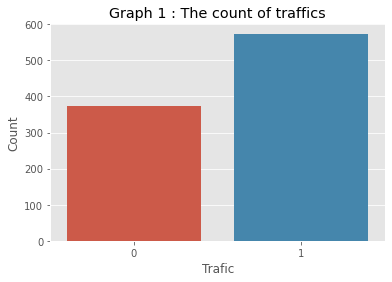

In [240]:
sns.countplot(x = df["high_traffic"]).set(title="Graph 1 : The count of traffics")
plt.xlabel("Trafic")
plt.ylabel("Count")
plt.show()

As shown in **Graph 1 : The count of traffics**, the most number of traffics are High. The "High" class is not significantly larger that the "Not High" so, we can conclude that the observations are balanced accross the two cateories.

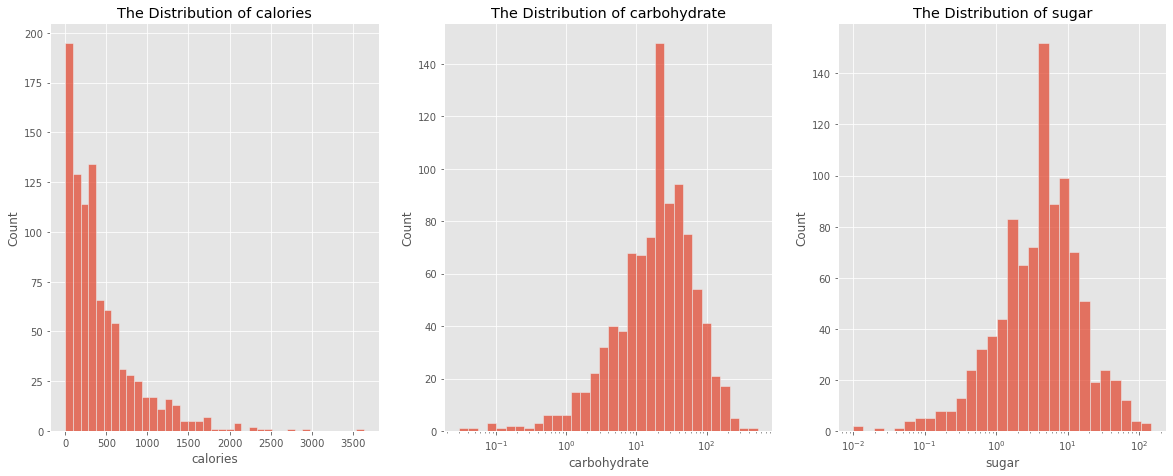

In [248]:
# distribution of calories, carbohydrate and sugar
fig, axes = plt.subplots(1,3,figsize=(20,7.5))
sns.histplot(df['calories'], ax=axes[0]).set(title='The Distribution of calories')
sns.histplot(df['carbohydrate'],log_scale=True, ax=axes[1]).set(title='The Distribution of carbohydrate');
sns.histplot(df['sugar'],log_scale=True, ax=axes[2]).set(title='The Distribution of sugar');

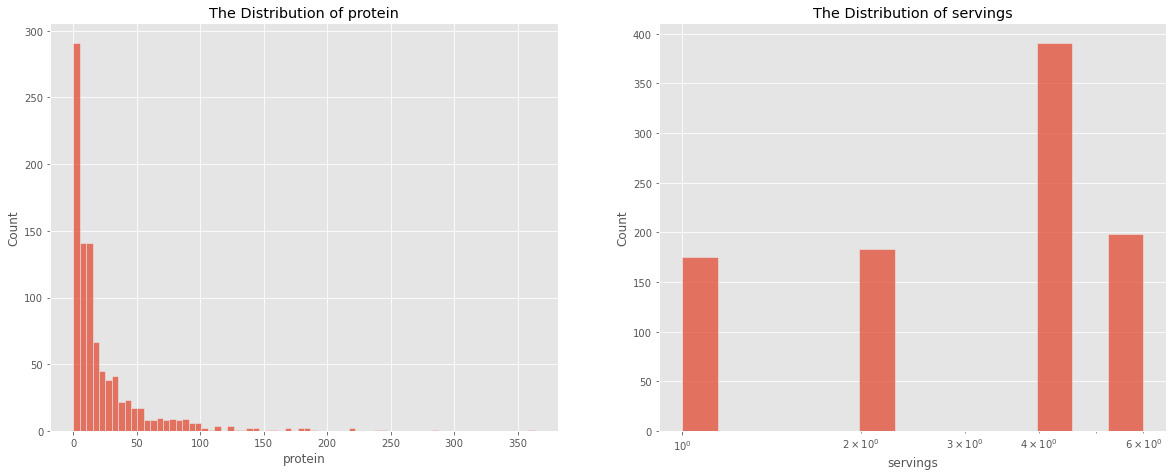

In [250]:
# distribution of protein, servings
fig, axes = plt.subplots(1,2,figsize=(20,7.5))
sns.histplot(df['protein'],ax=axes[0]).set(title='The Distribution of protein')
sns.histplot(df['servings'],log_scale=True, ax=axes[1]).set(title='The Distribution of servings');

### Numeric Variables : calories, carbohydrate, sugar, protein, servings

From the heatmap below, we can conclude that there is a moderate linear relationship between protein and calories.

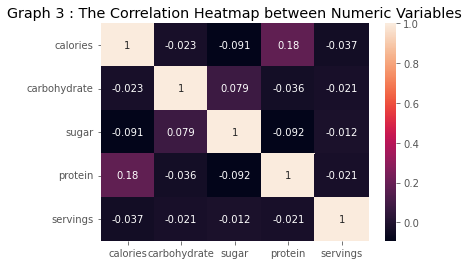

In [251]:
numeric = df[["calories","carbohydrate","sugar","protein","servings"]]
sns.heatmap(numeric.corr(), annot=True).set(title = 'Graph 3 : The Correlation Heatmap between Numeric Variables');

### Numeric Variables : category

From the chart below, the most frequents recipes in the dataset are firstly from Chicken and secondly from Breakfast.

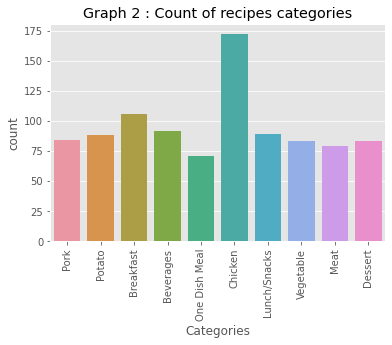

In [272]:
sns.countplot(x=df["category"]).set(title="Graph 2 : Count of recipes categories");
plt.xlabel("Categories");
plt.xticks(rotation = 90);

#### Normality tests for numerical variables : calories, carbohydrate, sugar, protein, servings

The signifiance threshold that we have set is 5%.

Numerical variables are not normaly distributed. So parametric tests like T-tests for mean comparison are not indicated here. So we are going to make usage of Kruskal-Wallis test to check wether a given numerical variable influences the target.

In [252]:
pg.normality(df["calories"])

,W,pval,normal
calories,0.797992,1.015775e-32,False


In [253]:
pg.normality(df["carbohydrate"])

,W,pval,normal
carbohydrate,0.666868,1.857445e-39,False


In [254]:
pg.normality(df["sugar"])

,W,pval,normal
sugar,0.543179,4.764415e-44,False


In [255]:
pg.normality(df["protein"])

,W,pval,normal
protein,0.624527,3.626981e-41,False


In [256]:
pg.normality(df["servings"])

,W,pval,normal
servings,0.855534,1.424854e-28,False


#### Kruskal-Wallis test between : calories, carbohydrate, sugar, protein, servings and target (High Traffic)

In [257]:
# Hight Trafic vs calories
pg.kruskal(data= df, dv="calories", between="high_traffic")

,Source,ddof1,H,p-unc
Kruskal,high_traffic,1,4.110551,0.042616


We can support a difference of calories between the recipes of the two groups (High Traffic and Not High).

In [258]:
# Hight Trafic vs carbohydrate
pg.kruskal(data= df, dv="carbohydrate", between="high_traffic")

,Source,ddof1,H,p-unc
Kruskal,high_traffic,1,3.894605,0.048441


We can support a difference of carbohydrates between the recipes of the two groups (High Traffic and Not High).

In [259]:
# Hight Trafic vs sugar
pg.kruskal(data= df, dv="sugar", between="high_traffic")

,Source,ddof1,H,p-unc
Kruskal,high_traffic,1,4.474275,0.034409


We can support a difference of sugar between the recipes of the two groups (High Traffic and Not High).

In [260]:
# Hight Trafic vs protein
pg.kruskal(data= df, dv="protein", between="high_traffic")

,Source,ddof1,H,p-unc
Kruskal,high_traffic,1,12.001051,0.000532


We can support a difference of protein between the recipes of the two groups (High Traffic and Not High).

In [170]:
# Hight Trafic vs servings
pg.kruskal(data= df, dv="servings", between="high_traffic")

,Source,ddof1,H,p-unc
Kruskal,high_traffic,1,2.175951,0.140183


We cannot support a difference of servings between the recipes of the two groups (High Traffic and Not High).

After performing these tests, it is probably relevant to use only the following numerical variables to predict the popularity of a recipe: calories, carbohydrates, sugar, protein.

To confirm I also performed a graphical analysis. From the boxplots below, we can see that there is a difference in the distribution of calories, carbohydrates, sugar, and protein between each category of the target variable. But the distribution of portions identical between the two groups.

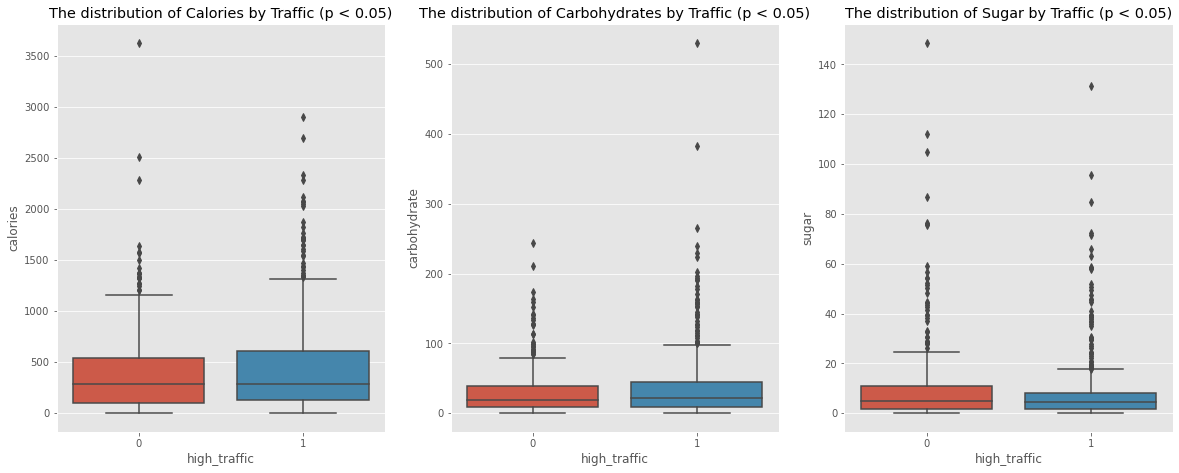

In [262]:
fig, axes = plt.subplots(1,3, figsize=(20,7.5))
sns.boxplot(data = df, x="high_traffic",y="calories", ax=axes[0]).set(title="The distribution of Calories by Traffic (p < 0.05)")
sns.boxplot(data = df, x="high_traffic",y="carbohydrate", ax=axes[1]).set(title="The distribution of Carbohydrates by Traffic (p < 0.05)")
sns.boxplot(data = df, x="high_traffic",y="sugar", ax=axes[2]).set(title="The distribution of Sugar by Traffic (p < 0.05)")
for ax in fig.axes:
    plt.sca(ax)

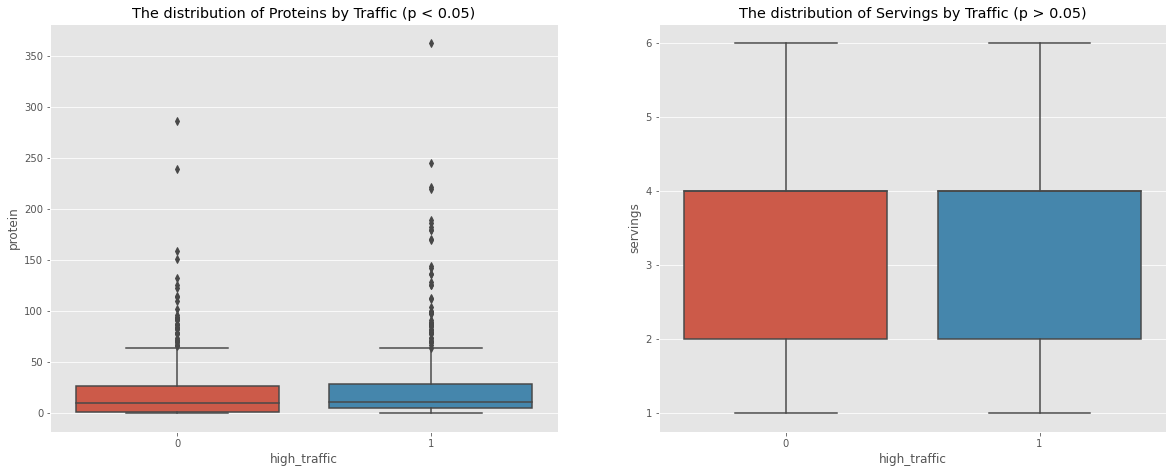

In [261]:
fig, axes = plt.subplots(1,2, figsize=(20,7.5))
sns.boxplot(data = df, x="high_traffic",y="protein", ax=axes[0]).set(title="The distribution of Proteins by Traffic (p < 0.05)")
sns.boxplot(data = df, x="high_traffic",y="servings", ax=axes[1]).set(title="The distribution of Servings by Traffic (p > 0.05)")
for ax in fig.axes:
    plt.sca(ax)

#### Relationship between : category and High Traffic  (Chi 2 independance)

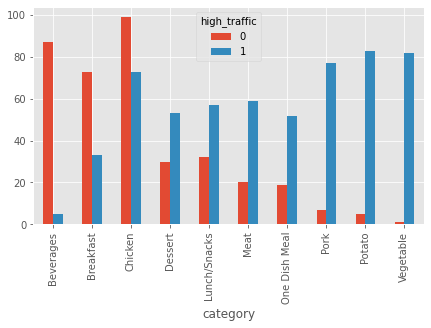

In [269]:
crossCategoryTraffic = pd.crosstab(index = df["category"], columns = df["high_traffic"])
crossCategoryTraffic.plot.bar(figsize=(7,4), rot=90);

In [263]:
res = chi2_contingency(pd.crosstab(df["category"], df["high_traffic"]), correction=True)
res.pvalue

3.417304408371102e-63

We can support that category and high_traffic are not independent.

## Model Fitting & Evaluation

Predicting which recipes will be populare is a classification problem in ML. I am choosing the **Decision tree** as a baseline model because it's simple and efficient to understand and implement, it's also robust to noises in the data and easy to interpret. 
The comparison model I'm choosing is the **Random Forest Classifier Model**, because it can capture more complex and nonlinear relationships between input features and target variables and its also relatively easy to interpret. 

I'm chosing : 
- Firstly the **accuracy score** to evaluate the model because it's commonly used and easy to interpret because it give us the percent of correct predictions made; The closer is that number to one, the better is the model
- Secondly the **precision** because it gave us the percentage of positive predictions that are correct. For our problem , the closer is that value to 80%, the better is the model.

### Prepare Data for Modelling

To enable modelling, i chose calories, carbohydrates, sugar, protein, categories as features, high_traffic as target variables. I also have made the following changes:

- Normalize the numeric features
- Convert the categorical variables into numeric features
- Split the data into a training set and a test set

In [176]:
# drop servings from features
df = df.drop(columns=["servings"])

In [177]:
df.columns

Index(['calories', 'carbohydrate', 'sugar', 'protein', 'category',
       'high_traffic'],
      dtype='object')

In [178]:
# define the encoder
labelencoder = LabelEncoder()
df['category'] = labelencoder.fit_transform(df['category'])

In [179]:
feature_cols = ['calories','carbohydrate','sugar','protein','category']
X = df[feature_cols] # Features
y = df['high_traffic'] # Target variable

In [180]:
# define the scaler 
scaler = PowerTransformer()
# fit and transform the numerical variables
X[['calories','carbohydrate','sugar','protein']] = \
scaler.fit_transform(X[['calories','carbohydrate','sugar','protein']])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [181]:
# split the dataset into 70% training set and 30% test set 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = SEED) 

### Decision Tree Classifier Model

In [182]:
dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(f"The accuracy of the Decision Tree Model is : {accuracy_score(y_test, y_pred_dt)}")

The accuracy of the Decision Tree Model is : 0.6736842105263158


#### Finding the feature importance

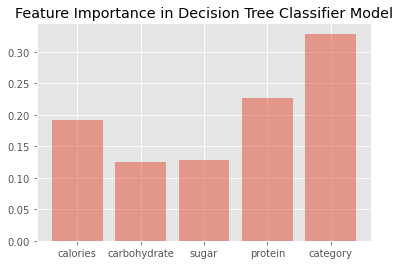

In [183]:
importance = dt.feature_importances_
new_col_names = ["calories","carbohydrate","sugar","protein","category"]
f_importance_dt = {}
for i in range(len(new_col_names)):
    f_importance_dt[new_col_names[i]] = importance[i]

plt.bar(f_importance_dt.keys(), f_importance_dt.values(), alpha =.5)
plt.title("Feature Importance in Decision Tree Classifier Model");

In [184]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print(f"The accuracy of the Random Forest Classifier Model is : {accuracy_score(y_test, y_pred_rfc)}")

The accuracy of the Random Forest Classifier Model is : 0.7298245614035088


#### Finding the best parameter for the Random Forest Classifier Model

Best max_depth is: 5 
Testing Accuracy is: 0.7684210526315789


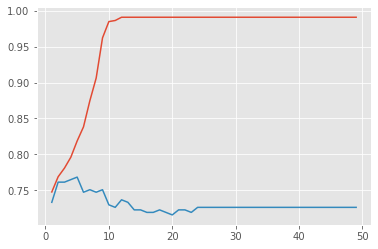

In [216]:
train_score = []
test_score = []
max_score = 0
max_pair = (0,0)

for i in range(1,50):
    rfc_ = RandomForestClassifier(max_depth=i,random_state=SEED)
    rfc_.fit(X_train,y_train)
    y_pred = rfc_.predict(X_test)
    train_score.append(rfc_.score(X_train,y_train))
    test_score.append(accuracy_score(y_test,y_pred))
    test_pair = (i,accuracy_score(y_test,y_pred))
    if test_pair[1] > max_pair[1]:
        max_pair = test_pair

fig, ax = plt.subplots()
ax.plot(np.arange(1,50), train_score, label = "Training Accuracy")
ax.plot(np.arange(1,50), test_score, label = "Testing Accuracy");
print(f'Best max_depth is: {max_pair[0]} \nTesting Accuracy is: {max_pair[1]}')

#### Finding the feature importance

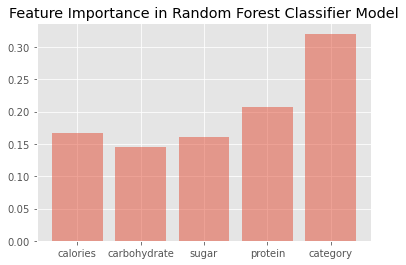

In [186]:
importance = rfc_.feature_importances_
new_col_names = ["calories","carbohydrate","sugar","protein","category"]
f_importance_rfc_ = {}
for i in range(len(new_col_names)):
    f_importance_rfc_[new_col_names[i]] = importance[i]

plt.bar(f_importance_rfc_.keys(), f_importance_rfc_.values(), alpha =.5)
plt.title("Feature Importance in Random Forest Classifier Model");

## Results

A greater accuracy (staying closer to one) value indicates the model has smaller errors in prediction.

Therefore, **Random Forest Classifier** (0,77) is performing better at predicting whether a recipe is popular or not based on that metric.

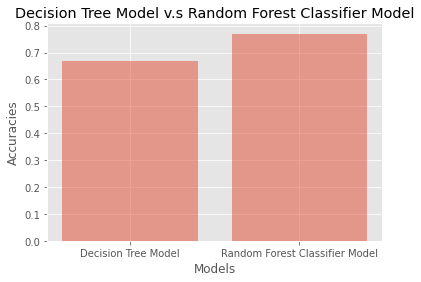

In [273]:
accuracies = [0.67,0.77]
labels =['Decision Tree Model','Random Forest Classifier Model']
plt.bar(labels, accuracies, alpha=0.5)

# Add labels to the chart
plt.title(f'{labels[0]} v.s {labels[1]}')
plt.xlabel('Models')
plt.ylabel('Accuracies')

# Show the chart
plt.show()

### Evaluate by Business Criteria

The company wants us to predict which recipes will be popular 80% of time and minimize the chance of showing unpopular recipes. Therefore, we would consider using the percentage of prediction popular 80% of time of the actual class as a KPI. That indicator refers to the precision for the “popularity” of a recipe. The closer that precision is to 80%, the better is the model. We can also use that KPI to compare the two models again. The closer the precision is to 80% the best is the model. For the popularity class : The random forest classifier has a precision of 78%, while the decision tree only has 75%. 

### Visualize the confusion matrixes

In [211]:
print(classification_report(y_test,y_pred_dt))
conf_matrix_dt = confusion_matrix(y_test,y_pred_dt)

              precision    recall  f1-score   support

           0       0.56      0.60      0.58       107
           1       0.75      0.72      0.73       178

    accuracy                           0.67       285
   macro avg       0.65      0.66      0.66       285
weighted avg       0.68      0.67      0.68       285



In [210]:
print(classification_report(y_test,rfc_.predict(X_test)))
conf_matrix_rfc_ = confusion_matrix(y_test,rfc_.predict(X_test))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       107
           1       0.78      0.78      0.78       178

    accuracy                           0.73       285
   macro avg       0.71      0.71      0.71       285
weighted avg       0.73      0.73      0.73       285



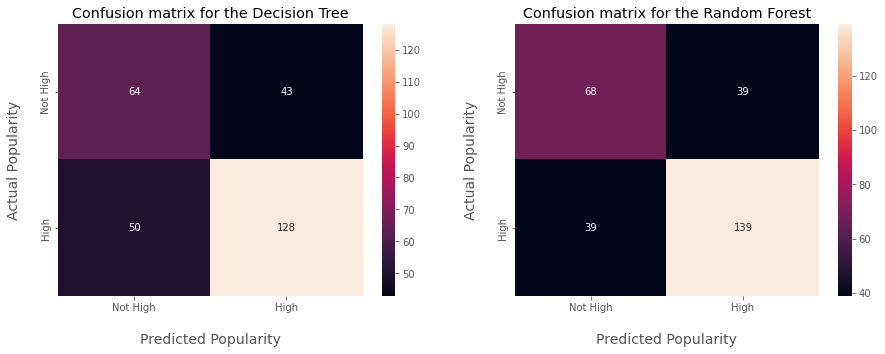

In [213]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(data = conf_matrix_dt, annot=True, ax=axes[0], fmt="d").set(title="Confusion matrix for the Decision Tree")
sns.heatmap(data = conf_matrix_rfc_, annot = True, ax=axes[1],fmt="d").set(title="Confusion matrix for the Random Forest")

for ax in fig.axes:    
    plt.sca(ax)
    
for i in range(2):
    axes[i].set_xlabel("Predicted Popularity", fontsize=14, labelpad=20);
    axes[i].xaxis.set_ticklabels(['Not High', 'High']);
    axes[i].set_ylabel("Actual Popularity", fontsize=14, labelpad=20);
    axes[i].yaxis.set_ticklabels(['Not High', 'High']);

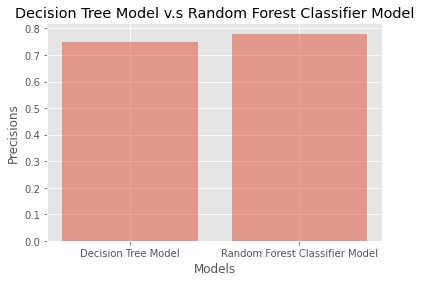

In [212]:
da = [0.75,0.78]
labels =['Decision Tree Model','Random Forest Classifier Model']
plt.bar(labels, da, alpha=0.5)

# Add labels to the chart
plt.title(f'{labels[0]} v.s {labels[1]}')
plt.xlabel('Models')
plt.ylabel('Precisions')

# Show the chart
plt.show()

## Recommendation 

In order to reduce the difficulties the company may encounter in the future, we may consider deploying this **Random Forest Classifier Model** in production. By implementing this model, we will be able to predict which recipe will be popular 78% of the time and minimize the
chance to show those who are unpopular. I will recommend the following steps to ensure the model can be deployed and improved on a regular basis.

1. Test the model over the last month and compare its prediction to the prediction of the experienced recipe website manager;

2. Identify and correct potential errors to improve accuracy after testing;

3. Fully deploy the model using an effective deployment strategy, such as a web or mobile app or API;

4. Continuously improve the model by collecting more data, feature engineer and fine-tuning parameter.